In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
path = Path("/kaggle/input/utkface-new/UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
print(len(filenames))
print(filenames[:3])

23708
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg']


In [4]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels,race_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

In [6]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'],df['race'] = image_path, age_labels, gender_labels, race_labels

In [7]:
#remove outliers
df = df[df['race'].isin(['0','1','2','3','4'])]
df['race'].value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: race, dtype: int64

In [8]:
df.head()

,image,age,gender,race
0,39_0_1_20170113151528768.jpg.chip.jpg,39,0,1
1,51_0_0_20170111203742983.jpg.chip.jpg,51,0,0
2,34_0_1_20170116002253177.jpg.chip.jpg,34,0,1
3,15_1_2_20170104012024121.jpg.chip.jpg,15,1,2
4,22_1_0_20170116214345265.jpg.chip.jpg,22,1,0


In [71]:
df.tail()

,image,age,gender,race
23703,4_0_3_20161220223111195.jpg.chip.jpg,4,0,3
23704,3_1_0_20170109192006973.jpg.chip.jpg,3,1,0
23705,3_1_0_20161219225130536.jpg.chip.jpg,3,1,0
23706,26_0_4_20170103235404028.jpg.chip.jpg,26,0,4
23707,29_0_1_20170117180836731.jpg.chip.jpg,29,0,1


In [9]:
gender_dict = {0:"Male",1:"Female"}

In [10]:
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

In [12]:
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

In [13]:
print(df.dtypes)

image     object
age        int32
gender     int32
race       int32
dtype: object


In [14]:
df.head()

,image,age,gender,race
0,39_0_1_20170113151528768.jpg.chip.jpg,39,0,1
1,51_0_0_20170111203742983.jpg.chip.jpg,51,0,0
2,34_0_1_20170116002253177.jpg.chip.jpg,34,0,1
3,15_1_2_20170104012024121.jpg.chip.jpg,15,1,2
4,22_1_0_20170116214345265.jpg.chip.jpg,22,1,0


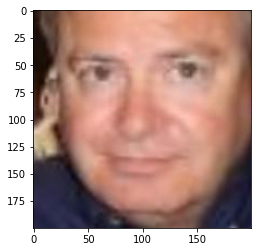

In [15]:
img = Image.open("/kaggle/input/utkface-new/UTKFace/"+df['image'][1])
plt.imshow(img)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='race', ylabel='Density'>

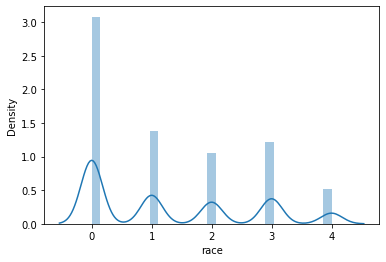

In [72]:
sns.distplot(df.race)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

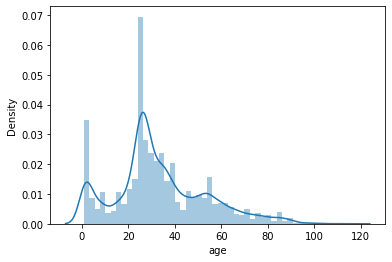

In [16]:
sns.distplot(df.age)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='gender', ylabel='count'>

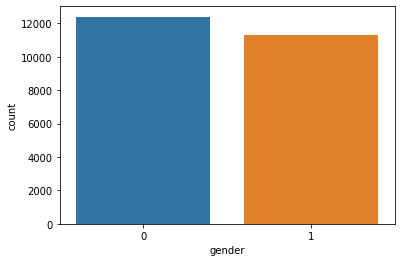

In [17]:
sns.countplot(df.gender)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='race', ylabel='count'>

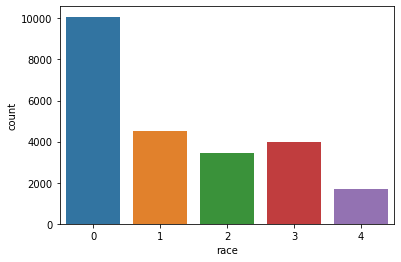

In [18]:
sns.countplot(df.race)

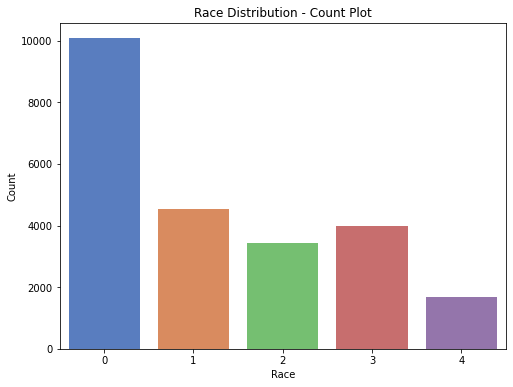

In [74]:

plt.figure(figsize=(8, 6))
sns.countplot(x='race', data=df, palette="muted")
plt.title('Race Distribution - Count Plot')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()


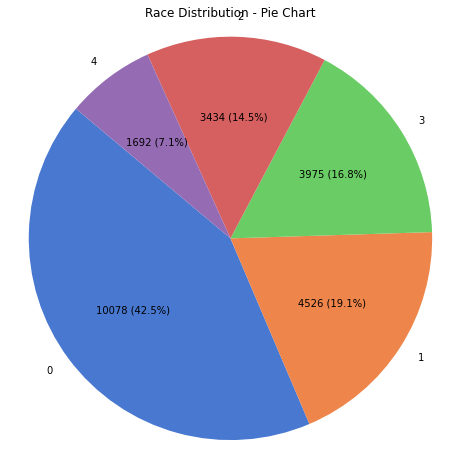

In [76]:

race_counts = df['race'].value_counts()
labels = race_counts.index
sizes = race_counts.values

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val:d} ({pct:.1f}%)'
    return my_format

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct=autopct_format(sizes), startangle=140, colors=sns.color_palette("muted"))
plt.title('Race Distribution - Pie Chart')
plt.axis('equal') 
plt.show()

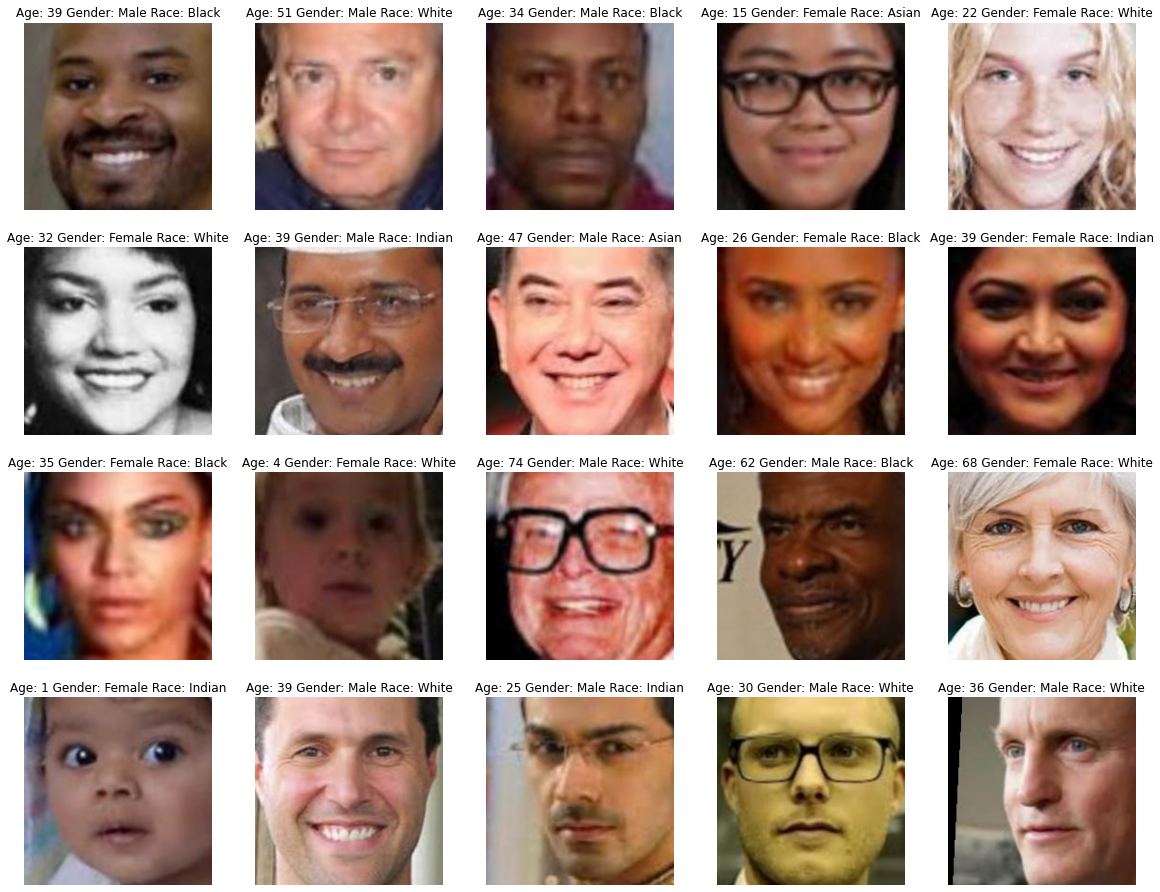

In [21]:
files = df.iloc[0:20]
plt.figure(figsize=(20,20))
for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender] } Race: {race_dict[race]}")
    plt.axis('off')

In [23]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [24]:
train.shape

(18964, 4)

In [25]:
test.shape

(4741, 4)

In [26]:
train.head()

,image,age,gender,race
21098,23_0_1_20170114033536005.jpg.chip.jpg,23,0,1
20881,25_1_4_20170103223722679.jpg.chip.jpg,25,1,4
21548,7_0_0_20170110215612275.jpg.chip.jpg,7,0,0
13628,42_1_0_20170112235933106.jpg.chip.jpg,42,1,0
8225,39_0_0_20170104204347174.jpg.chip.jpg,39,0,0


In [28]:

x_train = []
for file in train.image:
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 224, 224, 3)

In [29]:
x_train.shape

(18964, 224, 224, 3)

In [31]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)
y_race = np.array(train.race)

In [32]:
from tensorflow.keras.utils import to_categorical
y_race = to_categorical(y_race, num_classes=5)

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform


In [35]:
# Load the VGG16 model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the VGG16 layers
for layer in conv_base.layers:
    layer.trainable = False
# Input layer
input_size = (224, 224, 3)
inputs = Input(input_size)
# Apply the VGG16 base model
X = conv_base(inputs)
# Flatten the output
X = Flatten()(X)

# Dense layers for shared representation
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.4)(dense_1)

# Dense layers specific to each task
dense_2 = Dense(256, activation='relu')(dropout_1)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation='relu')(dropout_2)
dropout_3 = Dropout(0.4)(dense_3)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)  # Gender output
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)      # Age output
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)    # Race output

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    input_2[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg16[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          6422784     flatten[0][0]                    
_____________________________

In [36]:
# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mean_absolute_error',
        'race_output': 'accuracy'
    }
)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    input_2[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg16[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          6422784     flatten[0][0]                    
______________________________________________________________________________________________

In [38]:
y_race

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [39]:
# Train the model
history = model.fit(
    x_train,
    {
        'gender_output': y_gender,
        'age_output': y_age,
        'race_output': y_race
    },
    epochs=20,  
    batch_size=32,  
    validation_split=0.1 
)

Epoch 1/20
534/534 [==============================] - 49s 74ms/step - loss: 374.6819 - gender_output_loss: 2.4486 - age_output_loss: 368.1179 - race_output_loss: 4.1150 - gender_output_accuracy: 0.5848 - age_output_mean_absolute_error: 13.3346 - race_output_accuracy: 0.3312 - val_loss: 364.8366 - val_gender_output_loss: 0.7538 - val_age_output_loss: 362.6179 - val_race_output_loss: 1.4649 - val_gender_output_accuracy: 0.6210 - val_age_output_mean_absolute_error: 14.6197 - val_race_output_accuracy: 0.4054
Epoch 2/20
534/534 [==============================] - 37s 68ms/step - loss: 165.7020 - gender_output_loss: 0.7537 - age_output_loss: 163.4531 - race_output_loss: 1.4953 - gender_output_accuracy: 0.5681 - age_output_mean_absolute_error: 9.6146 - race_output_accuracy: 0.4144 - val_loss: 314.6178 - val_gender_output_loss: 0.6518 - val_age_output_loss: 312.5320 - val_race_output_loss: 1.4339 - val_gender_output_accuracy: 0.6025 - val_age_output_mean_absolute_error: 13.7550 - val_race_outpu

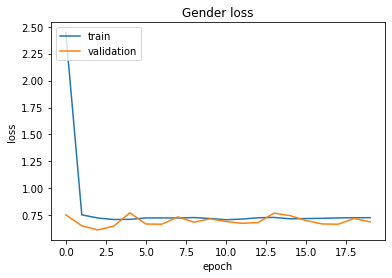

In [42]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

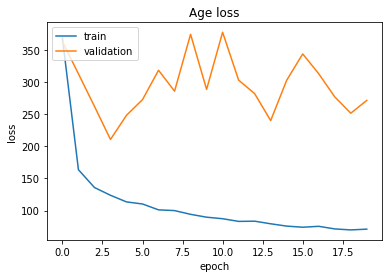

In [43]:
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

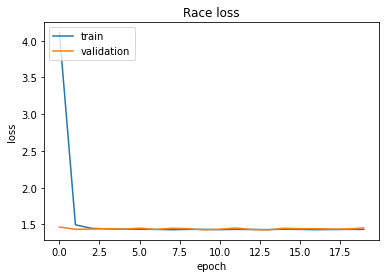

In [44]:
plt.plot(history.history['race_output_loss'])
plt.plot(history.history['val_race_output_loss'])
plt.title('Race loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
race_dict

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

Original: Gender =  Female  Age =  28  Race =  White
Prediction: Gender =  Female  Age =  24  Race =  White


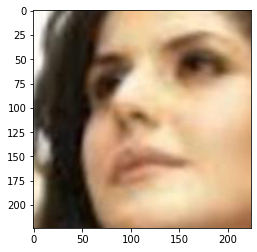

In [110]:
index = 20

gender = gender_dict[y_gender[index].item()] if isinstance(y_gender[index], np.ndarray) else gender_dict[y_gender[index]]
age = y_age[index].item() if isinstance(y_age[index], np.ndarray) else y_age[index]
race = race_dict[y_race[index][0]] if isinstance(y_race[index], np.ndarray) else race_dict[y_race[index]]

print("Original: Gender = ", gender, " Age = ", age, " Race = ", race)

pred = model.predict(x_train[index].reshape(1, 224, 224, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[round(np.argmax(pred[2][0]))]

print("Prediction: Gender = ", pred_gender, " Age = ", pred_age, " Race = ", pred_race)

plt.imshow(x_train[index].reshape(224, 224, 3))
plt.show()


In [ ]:
test.head()

In [51]:
#converting Image to numpy array (extracting feature)
x_test = []
for file in test.image:
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file, grayscale=True)
    
    img = img.resize((224, 224), Image.ANTIALIAS)
    img = np.array(img)
    x_test.append(img)

x_test = np.array(x_test)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  


In [52]:

y_gender_test = test['gender'].values
y_age_test = test['age'].values
y_race_test = test['race'].values
y_race_test = to_categorical(y_race_test, num_classes=5)

In [58]:
import numpy as np

x_test_rgb = np.repeat(x_test, 3, axis=-1)  
test_acc = model.evaluate(x_test_rgb, {'gender_output': y_gender_test, 'age_output': y_age_test, 'race_output': y_race_test}, verbose=0)


In [59]:
print('total loss:', test_acc[0])
print('gender loss:', test_acc[1])
print('age loss:', test_acc[2])
print('race loss:', test_acc[3])
print('gender accuracy:', test_acc[4])
print('age mean absolute error:', test_acc[5])
print('race accuracy:', test_acc[6])

total loss: 326.4628601074219
gender loss: 0.6998841762542725
age loss: 324.33428955078125
race loss: 1.428654432296753
gender accuracy: 0.5266821384429932
age mean absolute error: 13.892417907714844
race accuracy: 0.4273360073566437


In [65]:
pred[2][0]

array([0.378769  , 0.20295414, 0.1547507 , 0.17829362, 0.08523255],
      dtype=float32)

In [66]:
pred_gender = []
for i in pred[0]:
    pred_gender.append(gender_dict[round(i[0])])

pred_age = []
for i in pred[1]:
    pred_age.append(round(i[0]))

pred_race = []
for i in pred[2]:
    pred_race.append(race_dict[round(np.argmax(i))])

In [67]:
#pred to df
df_pred = pd.DataFrame({'gender': pred_gender, 'age': pred_age, 'race': pred_race})

In [68]:
df_pred['gender'].value_counts()

Female    1
Name: gender, dtype: int64

In [69]:
df_pred['age'].value_counts()

24    1
Name: age, dtype: int64

In [70]:
df_pred['race'].value_counts()

White    1
Name: race, dtype: int64

In [112]:
# Assuming 'model' is your trained Keras model
model.save('model.h5')
